<a href="https://colab.research.google.com/github/Adam-Yasser/Potato-Virus-Detection-Using-EfficientNetB1/blob/main/Potato_Viral_Diseases_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow keras

In [ ]:
import opendatasets as od
from google.colab import files
import pandas as pd
import numpy as np
import shap
import kagglehub
import os
import seaborn as sns
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
import albumentations as A
import torch
import torch.nn as nn
from torchvision import models
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import random
from sklearn.metrics import confusion_matrix, matthews_corrcoef, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from scipy.stats import ks_2samp, mannwhitneyu
import statsmodels.stats.proportion as smp

In [ ]:
od.download("https://www.kaggle.com/datasets/nirmalsankalana/potato-viral-disease-dataset/data?select=Potato___spindle_tuber_viroid")

Skipping, found downloaded files in "./potato-viral-disease-dataset" (use force=True to force download)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations=None, im_files=(".png", ".jpg"), mode="train"):
        self.mode = mode
        self.transformations = transformations.get(mode, None)
        self.im_paths = self.get_image_paths(root, im_files)
        self.cls_names, self.cls_counts = self.get_class_info()

    def get_image_paths(self, root, im_files):
        paths = []
        for ext in im_files:
            paths.extend(sorted(glob(f"{root}/*/*{ext}")))
        return paths

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1].split("___")[-1]

    def get_class_info(self):
        cls_names = {}
        cls_counts = {}
        index = 0

        for path in self.im_paths:
            class_name = self.get_class(path)
            if class_name not in cls_names:
                cls_names[class_name] = index
                cls_counts[class_name] = 1
                index += 1
            else:
                cls_counts[class_name] += 1

        return cls_names, cls_counts

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        image = Image.open(im_path).convert("RGB")
        gt_label = self.cls_names[self.get_class(im_path)]

        if self.transformations:
            image = self.transformations(image)
        return image, gt_label

In [ ]:
def get_dataloaders(root, transformations, batch_size, split=(0.9, 0.05, 0.05), num_workers=0):
    dataset = CustomDataset(root=root, transformations=transformations, mode="train")
    total_len = len(dataset)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_dataset, vl_dataset, ts_dataset = random_split(dataset, [tr_len, vl_len, ts_len])

    tr_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    vl_loader = DataLoader(vl_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    ts_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

    return tr_loader, vl_loader, ts_loader, dataset.cls_names, dataset.cls_counts

In [ ]:
if __name__ == "__main__":
    root_dir = "/content/potato-viral-disease-dataset"
    mean, std, image_size, batch_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 16

    train_transforms = T.Compose([
    T.Resize((image_size, image_size)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
    ])

    val_transforms = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
        ])

    train_loader, val_loader, test_loader, classes, class_counts = get_dataloaders(
        root=root_dir,
        transformations={"train": train_transforms, "val": val_transforms},
        batch_size=batch_size,
        num_workers=0
    )
    dataset = CustomDataset(root=root_dir, transformations={"train": train_transforms, "val": val_transforms}, mode="train")

    for i in range(5):
        image, label = dataset[i]
        print(f"Image {i} type: {type(image)}, Label: {label}")

    train_loader, val_loader, test_loader, classes, class_counts = get_dataloaders(
        root=root_dir,
        transformations={"train": train_transforms, "val": val_transforms},
        batch_size=batch_size,
        num_workers=4
    )

    print("Total number of images per class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    print("Classes:", classes)

Image 0 type: <class 'torch.Tensor'>, Label: 0
Image 1 type: <class 'torch.Tensor'>, Label: 0
Image 2 type: <class 'torch.Tensor'>, Label: 0
Image 3 type: <class 'torch.Tensor'>, Label: 0
Image 4 type: <class 'torch.Tensor'>, Label: 0
Total number of images per class:
healthy: 135 images
leafroll_virus: 165 images
mosaic_virus: 269 images
Training batches: 32
Validation batches: 2
Test batches: 29
Classes: {'healthy': 0, 'leafroll_virus': 1, 'mosaic_virus': 2}


In [ ]:
def show_images_from_each_class(dataset, num_images_per_class=3, image_size=(256, 256)):
    class_images = {cls_name: [] for cls_name in dataset.cls_names}

    for img_path in dataset.im_paths:
        cls_name = dataset.get_class(img_path)
        if len(class_images[cls_name]) < num_images_per_class:
            class_images[cls_name].append(img_path)

    fig, axes = plt.subplots(len(class_images), num_images_per_class, figsize=(12, len(class_images)*4))
    axes = axes.flatten()

    resize_transform = transforms.Resize(image_size)

    img_idx = 0
    for cls_name, img_paths in class_images.items():
        for img_path in img_paths:
            img = Image.open(img_path).resize(image_size)
            ax = axes[img_idx]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{cls_name}")
            img_idx += 1

    plt.tight_layout()
    plt.show()

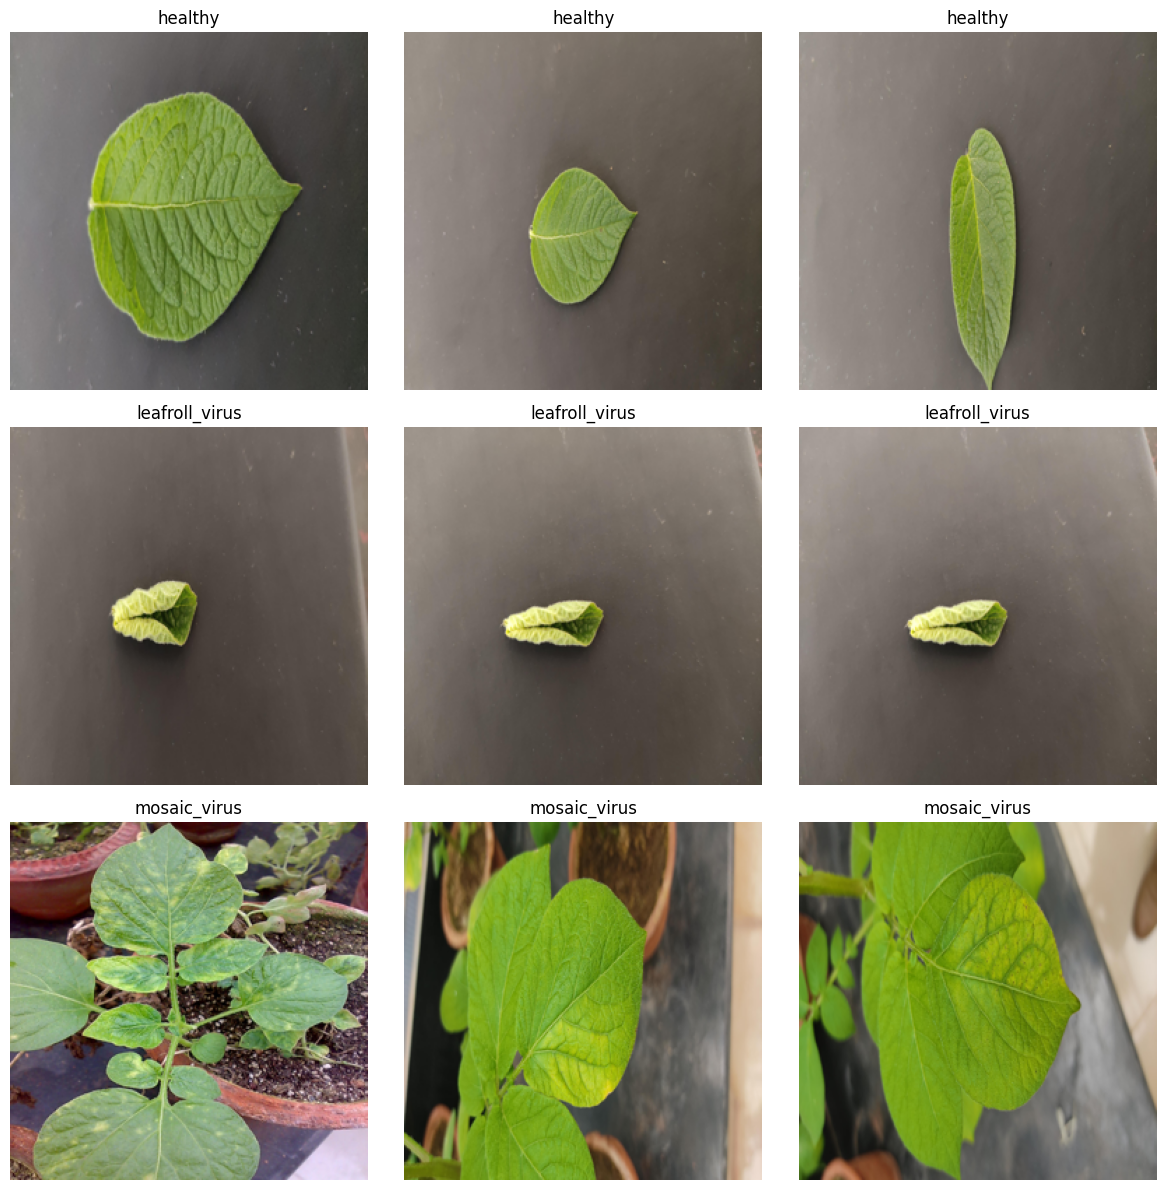

In [ ]:
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = CustomDataset(root=root_dir, transformations=transformations)

show_images_from_each_class(dataset, num_images_per_class=3, image_size=(256, 256))

## Detecting Corrupted Image

In [ ]:
def detect_corrupted_images(directory):
    corrupted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupted image detected: {file_path}")
                corrupted_files.append(file_path)
    return corrupted_files

In [ ]:
corrupted_images = detect_corrupted_images(root_dir)
print(f"Found {len(corrupted_images)} corrupted images.")

Found 0 corrupted images.


## Detecting Low-Quality Images

In [ ]:
def detect_small_images(directory, min_size=(100, 100)):
    small_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
                        print(f"Small image detected: {file_path}")
                        small_files.append(file_path)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return small_files

In [ ]:
small_images = detect_small_images(root_dir)
print(f"Found {len(small_images)} small images.")

Found 0 small images.


## Detecting Dark Images


In [ ]:
def detect_dark_or_bright_images(directory, dark_threshold=30, bright_threshold=220):
    dark_files = []
    bright_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    mean_brightness = np.mean(img)
                    if mean_brightness < dark_threshold:
                        print(f"Dark image detected: {file_path}")
                        dark_files.append(file_path)
                    elif mean_brightness > bright_threshold:
                        print(f"Bright image detected: {file_path}")
                        bright_files.append(file_path)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return dark_files, bright_files

In [ ]:
dark_images, bright_images = detect_dark_or_bright_images(root_dir)
print(f"Found {len(dark_images)} dark images and {len(bright_images)} bright images.")

Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0708.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0693.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0664.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0753.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0668.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0613.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0479.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0704.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0623.JPG
Dark image detected: /content/potato-viral-disease-dataset/Potato___leafroll_virus/DSC_0709.JPG
Dark image detected: /content/potato-vir

#### The 411 dark images is just have a black background; just keep them!


# The model


In [ ]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.base_model = models.efficientnet_b1(pretrained=True)
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, num_classes)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout(x)
        return x

In [ ]:
num_classes = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomEfficientNet(num_classes=num_classes).to(device)

## Training and Validation Setup

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader), correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(val_loader), correct / total

## Hyperparameter Tuning with ReduceLROnPlateau


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 7
train_losses, val_losses = [], []

## Validation and Training

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
patience = 3
counter = 0

print(f"{'Epoch':<6} | {'Train Loss':<12} | {'Validation Loss':<15} | {'Train Acc':<12} | {'Validation Acc':<15}")
print("-" * 68)

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    print(f"{epoch+1:<6} | {train_loss:<12.4f} | {val_loss:<15.4f} | {train_acc:<12.4f} | {val_acc:<15.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch  | Train Loss   | Validation Loss | Train Acc    | Validation Acc 
--------------------------------------------------------------------
1      | 0.3150       | 0.2033          | 0.8848       | 0.9643         
2      | 0.1436       | 0.0249          | 0.9473       | 1.0000         
3      | 0.0903       | 0.0116          | 0.9648       | 1.0000         
4      | 0.0690       | 0.0024          | 0.9805       | 1.0000         
5      | 0.0349       | 0.0012          | 0.9824       | 1.0000         
Early stopping at epoch 5


In [ ]:
torch.save(model.state_dict(), 'final_model_1_.pth')

## Evaluation the model

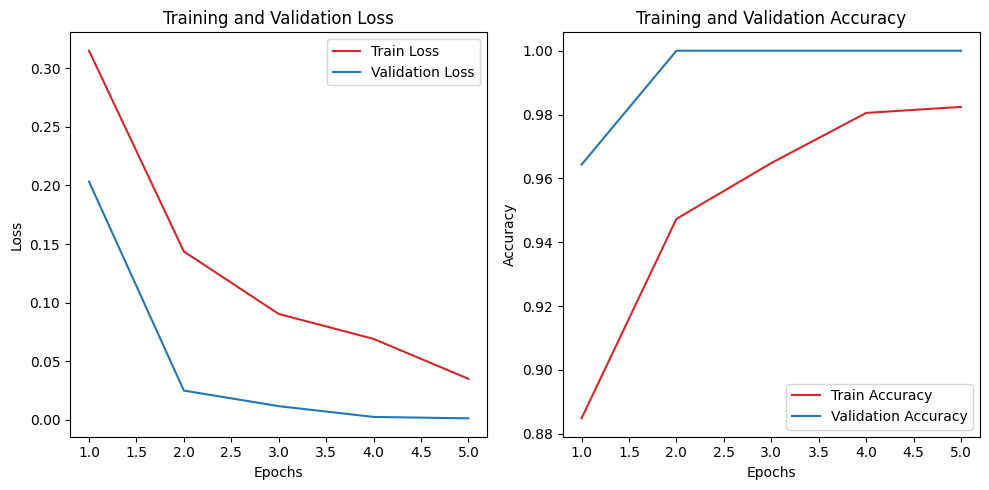

In [ ]:
def learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='tab:red')
    plt.plot(epochs, val_losses, label='Validation Loss', color='tab:blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='tab:red')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='tab:blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

### Loss Difference Plot (Gap Between Training & Validation Loss)

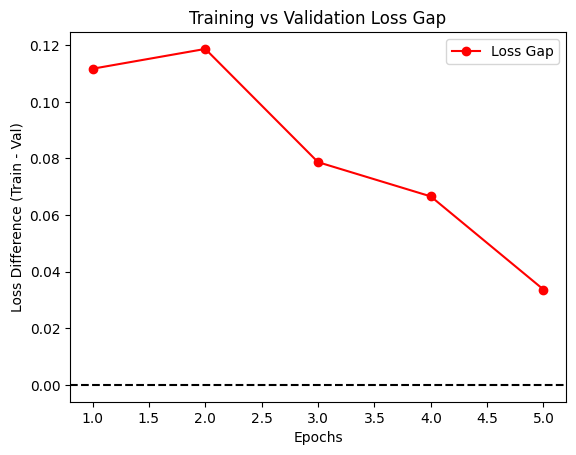

In [ ]:
epochs = range(1, len(train_losses) + 1)
loss_gap = np.array(train_losses) - np.array(val_losses)

plt.plot(epochs, loss_gap, marker='o', linestyle='-', color='red', label='Loss Gap')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference (Train - Val)')
plt.title('Training vs Validation Loss Gap')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

### Accuracy Difference Plot (Gap Between Training & Validation Accuracy)

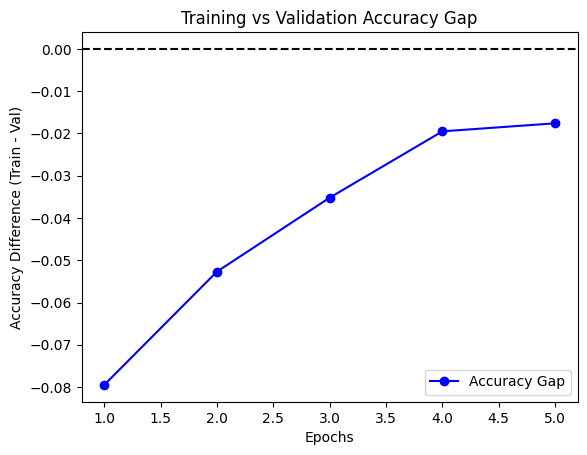

In [ ]:
accuracy_gap = np.array(train_accuracies) - np.array(val_accuracies)
plt.plot(epochs, accuracy_gap, marker='o', linestyle='-', color='blue', label='Accuracy Gap')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference (Train - Val)')
plt.title('Training vs Validation Accuracy Gap')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

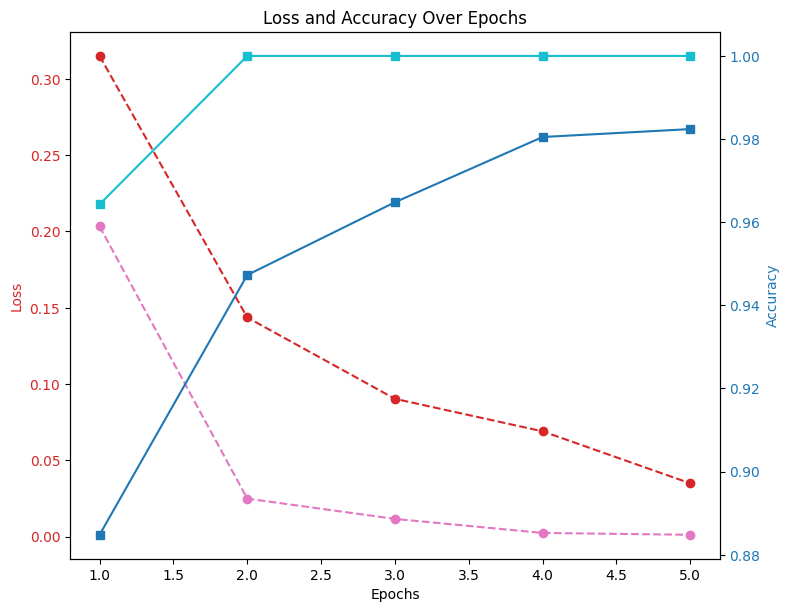

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, train_losses, label='Train Loss', marker='o', color='tab:red', linestyle='dashed')
ax1.plot(epochs, val_losses, label='Val Loss', marker='o', color='tab:pink', linestyle='dashed')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(epochs, train_accuracies, label='Train Accuracy', marker='s', color='tab:blue')
ax2.plot(epochs, val_accuracies, label='Val Accuracy', marker='s', color='tab:cyan')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title('Loss and Accuracy Over Epochs')
plt.show()

### Relative Change in Loss & Accuracy Over Epochs

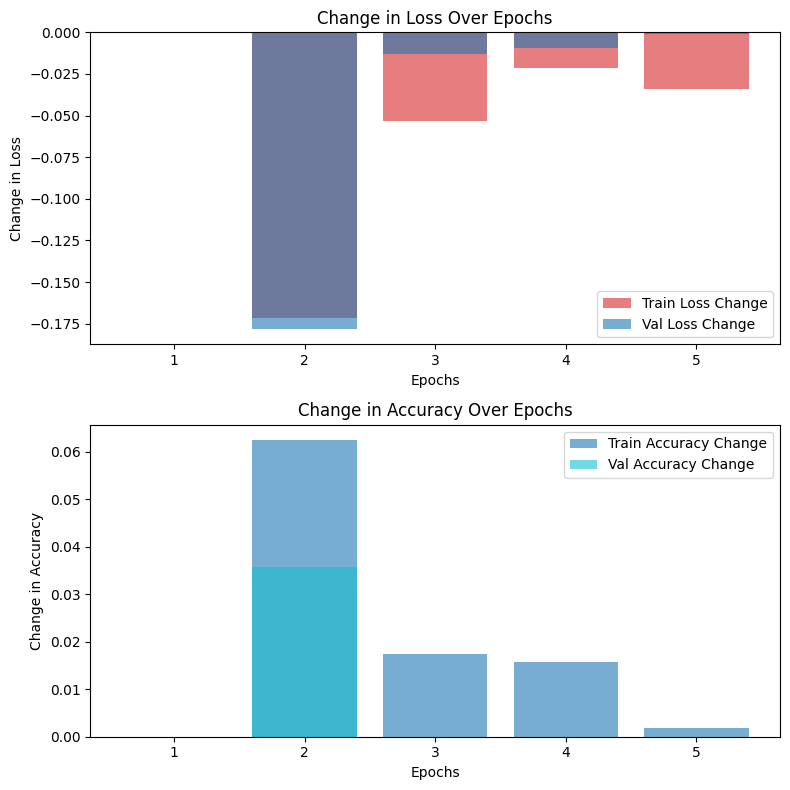

In [ ]:
train_loss_change = np.diff(train_losses, prepend=train_losses[0])
val_loss_change = np.diff(val_losses, prepend=val_losses[0])
train_acc_change = np.diff(train_accuracies, prepend=train_accuracies[0])
val_acc_change = np.diff(val_accuracies, prepend=val_accuracies[0])

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].bar(epochs, train_loss_change, label='Train Loss Change', color='tab:red', alpha=0.6)
ax[0].bar(epochs, val_loss_change, label='Val Loss Change', color='tab:blue', alpha=0.6)
ax[0].set_title('Change in Loss Over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Change in Loss')
ax[0].legend()

ax[1].bar(epochs, train_acc_change, label='Train Accuracy Change', color='tab:blue', alpha=0.6)
ax[1].bar(epochs, val_acc_change, label='Val Accuracy Change', color='tab:cyan', alpha=0.6)
ax[1].set_title('Change in Accuracy Over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Change in Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
def compute_metrics(model, val_loader, device, num_classes):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    return np.array(y_true), np.array(y_probs)

## ROC


In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
def plot_overall_roc_curve(y_true, y_probs, num_classes):
    y_true_one_hot = np.eye(num_classes)[y_true]

    fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), np.array(y_probs).ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'Model ROC (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Overall Model ROC Curve')
    plt.legend()
    plt.show()

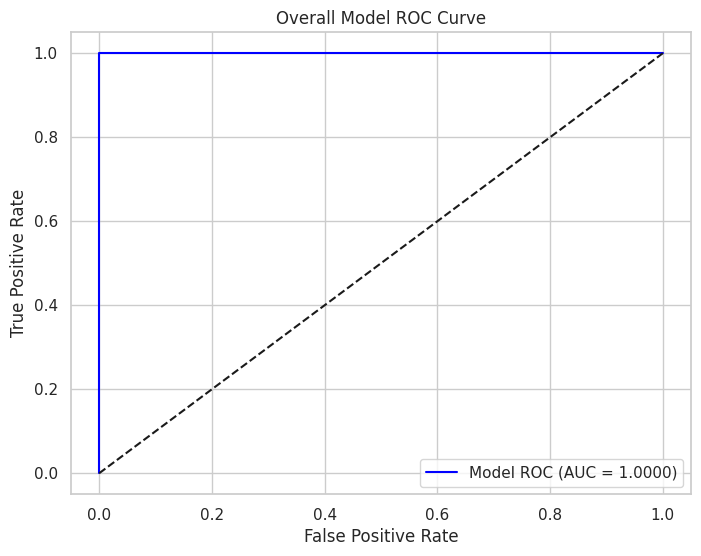

In [ ]:
plot_overall_roc_curve(y_true, y_probs, num_classes)

## Confusion Matrix using Heatmap

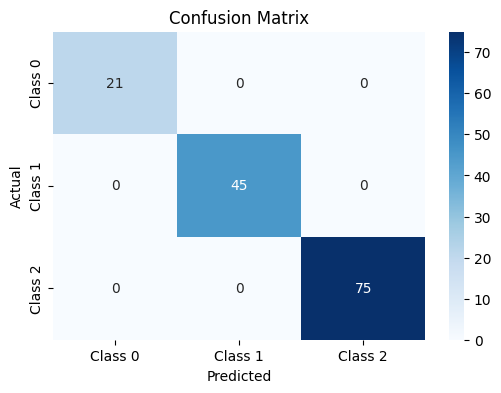

In [ ]:
def plot_confusion_matrix(model, val_loader, device, num_classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(model, val_loader, device, num_classes=3)

In [ ]:
def apply_gradcam(model, image, target_layer, device):
    model.eval()
    image = image.to(device)

    gradients = []
    activations = []

    def save_activation(module, input, output):
        activations.append(output)

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)

    image = image.unsqueeze(0)
    output = model(image)
    pred_class = output.argmax(dim=1)
    loss = output[0, pred_class]

    model.zero_grad()
    loss.backward()

    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]

    weights = np.mean(gradient, axis=(1, 2))
    cam = np.zeros(activation.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activation[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.shape[2], image.shape[3]))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    return cam, output

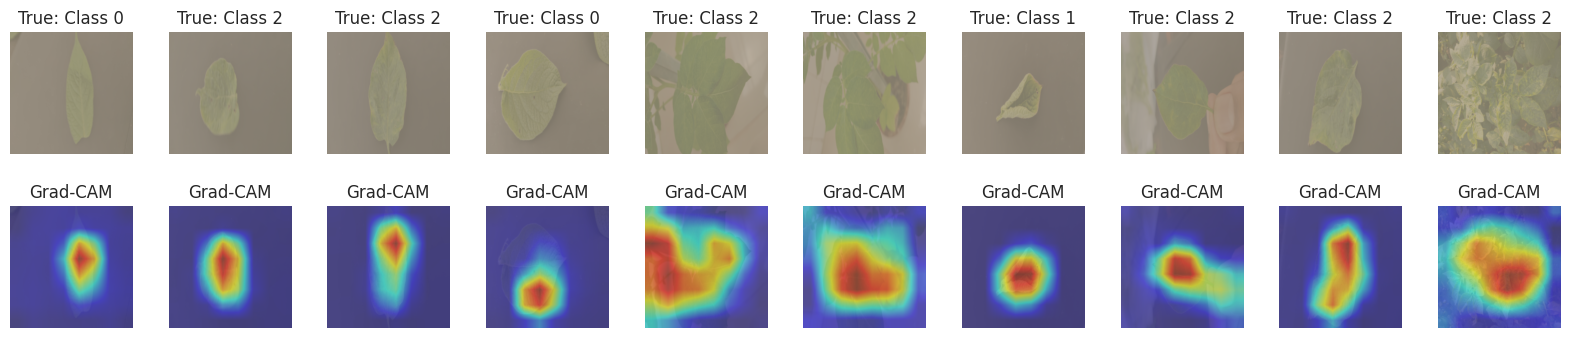

In [ ]:
sample_images, sample_labels = next(iter(val_loader))
num_images = min(10, sample_images.shape[0])
sample_images = sample_images[:num_images]
sample_labels = sample_labels[:num_images]

target_layer = model.base_model.features[-1]

class_names = ["Class 0", "Class 1", "Class 2"]

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(num_images):
    img = sample_images[i]
    label = sample_labels[i].item()

    gradcam_result, logits = apply_gradcam(model, img, target_layer, device)

    image_np = img.cpu().numpy().transpose(1, 2, 0)
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image_np = np.clip(image_np, 0, 1)
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_result), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlayed_image = (0.5 * heatmap + 0.5 * image_np)

    axes[0, i].imshow(image_np)
    axes[0, i].set_title(f"True: {class_names[label]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(overlayed_image)
    axes[1, i].set_title("Grad-CAM")
    axes[1, i].axis("off")

plt.show()

## Some of statistical Performance Validation

### Kolmogorov-Smirnov (KS) Test

In [ ]:
ks_stat, p_value_ks = ks_2samp(train_accuracies, val_accuracies)
print(f"KS Statistic: {ks_stat:.4f}, P-value: {p_value_ks:.4f}")
if p_value_ks > 0.05:
    print("No significant difference between training and validation accuracies, suggesting no overfitting.")
else:
    print("Significant difference detected, possible overfitting")

KS Statistic: 0.1000, P-value: 1.0000
No significant difference between training and validation accuracies, suggesting no overfitting.


### Mann-Whitney U Test

In [ ]:
mann_stat, p_value_mann = mannwhitneyu(train_losses, val_losses, alternative='two-sided')
print(f"Mann-Whitney U Statistic: {mann_stat:.4f}, P-value: {p_value_mann:.4f}")
if p_value_mann > 0.05:
    print("No significant difference between training and validation losses, suggesting no overfitting.")
else:
    print("Significant difference detected, possible overfitting.")

Mann-Whitney U Statistic: 44.0000, P-value: 0.6774
No significant difference between training and validation losses, suggesting no overfitting.
